# Party similarity by vote adherence to party lines

In [1]:
%matplotlib inline
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from IPython.display import display
from elections import models as election_models
from parliaments import models as parliament_models
from proceedings import models as proceeding_models
from django_extensions.db.fields.json import JSONDict
from collections import OrderedDict
from federal_common.sources import EN, FR
from django.db.models.base import ModelBase
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import os

def columns_reorder_left(dataframe, columns):
    unmentioned = [column for column in dataframe.columns if column not in columns]
    dataframe = dataframe[columns + unmentioned]
    return dataframe

def columns_reorder_after(dataframe, pairs):
    columns = list(dataframe.columns)
    for left, right in pairs.items():
        columns.remove(right)
        columns.insert(columns.index(left) + 1, right)
    return dataframe[columns]

dataframe_json_mapper = {
    "government_party": "Library of Parliament, History of Federal Ridings",
    "party": "Library of Parliament, History of Federal Ridings",
    "province": "Library of Parliament, Province / Territory File",
    "riding": "Library of Parliament, History of Federal Ridings",
    "parliamentarian": "Library of Parliament, Parliament File",
}

def get_dataframe(qs, mapping, index=None):
    mapping = OrderedDict(mapping)
    qs = qs.objects.all() if isinstance(qs, ModelBase) else qs
    dataframe = pd.DataFrame(
        {
            k: v.get(EN, {}).get(dataframe_json_mapper[k.split("__")[-2]], "") if isinstance(v, dict) else v
            for k, v in row_dict.items()
        }
        for row_dict in qs.values(*[
            key[0] if isinstance(key, tuple) else key
            for key in mapping.keys()
        ])
    )
    dataframe = columns_reorder_left(dataframe, list(mapping.keys()))
    dataframe.rename(columns=mapping, inplace=True)
    if index:
        dataframe = dataframe.set_index(index)
    dataframe = dataframe.sort_index()
    return dataframe

def select_by_index(dataframe, indexes):
    indexer = [slice(None)] * len(dataframe.index.names)
    for key, value in indexes.items():
        indexer[dataframe.index.names.index(key)] = value
    if len(indexer) > 1:
        return dataframe.loc[tuple(indexer), :]
    else:
        return dataframe.loc[tuple(indexer)]

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes."""
    # calculate evenly-spaced axis angles
    theta = 2 * np.pi * np.linspace(0, 1 - 1. / num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi / 2

    def draw_poly_frame(self, x0, y0, r):
        # TODO: use transforms to convert (x, y) to (r, theta)
        verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_frame(self, x0, y0, r):
        return plt.Circle((x0, y0), r)

    frame_dict = {'polygon': draw_poly_frame, 'circle': draw_circle_frame}
    if frame not in frame_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        """Class for creating a radar chart (a.k.a. a spider or star chart)
        http://en.wikipedia.org/wiki/Radar_chart
        """
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_frame = frame_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180 / np.pi, labels)

        def _gen_axes_patch(self):
            x0, y0 = (0.5, 0.5)
            r = 0.5
            return self.draw_frame(x0, y0, r)

    register_projection(RadarAxes)
    return theta

def display_toggler(button="Click to toggle"):
    return HTML("""
        <script>
            function toggle_cell(event) {{
                $(event ? event.target : ".toggler")
                    .parents(".output_wrapper")
                    .prev()
                    .toggle(event ? undefined : false)
            }}
            $(document).ready(setTimeout(toggle_cell, 0))
        </script>
        <p><button class="toggler" onClick="javascript:toggle_cell(event)">{}</button></p>
    """.format(button))

display_toggler("Click to toggle the display the initializing scripts")

In [2]:
elections = get_dataframe(election_models.GeneralElection, {
    "number": "Election",
    "date": "Date",
    "population": "Population",
    "registered": "Registered",
    "ballots_total": "Ballots (Total)",
    "parliament__seats": "Seats",
    "parliament__government_party__names": "Party",
}, ["Election"])
elections['Date'] = pd.to_datetime(elections['Date'])  # TODO: Why isn't this happening automatically?
ridings = get_dataframe(election_models.ElectionRiding.objects.filter(general_election__isnull=False), {
    "general_election__number": "Election",
    "general_election__date": "Election: Date",
    "riding__province__names": "Province",
    "riding__names": "Riding",
    "population": "Population",
    "registered": "Registered",
    "ballots_rejected": "Ballots (Rejected)"
}, ["Election", "Province", "Riding"])
ridings['Election: Date'] = pd.to_datetime(ridings['Election: Date'])
candidates = get_dataframe(election_models.ElectionCandidate.objects.filter(election_riding__general_election__isnull=False), {
    "election_riding__general_election__number": "Election",
    "election_riding__general_election__date": "Election: Date",
    "election_riding__riding__province__names": "Province",
    "election_riding__riding__names": "Riding",
    "name": "Candidate",
    "party__names": "Party",
    "party__color": "Party: Color",
    "election_riding__population": "Riding: Population",
    "election_riding__registered": "Riding: Registered",
    "ballots": "Ballots",
    "elected": "Elected",
    "acclaimed": "Acclaimed",
}, ["Election", "Province", "Riding", "Candidate"])
candidates['Election: Date'] = pd.to_datetime(candidates['Election: Date'])
house_vote_participants = get_dataframe(proceeding_models.HouseVoteParticipant.objects.all(), {
    "house_vote__sitting__session__parliament__number": "Parliament",
    "house_vote__sitting__session__number": "Session",
    "house_vote__sitting__number": "Sitting",
    "house_vote__number": "Vote",
    "party__names": "Party",
    "parliamentarian__names": "Parliamentarian",
    "recorded_vote": "Parliamentarian: Vote",
}, ["Parliament", "Session", "Sitting", "Vote", "Party", "Parliamentarian"])
house_vote_participants = house_vote_participants.reset_index().fillna("Independent").set_index(house_vote_participants.index.names)

# Some ridings historically had two seats (Halifax, Victoria, etc). For the purposes of
# calculating voter turnout, we need to define a fractional ballot where a voter's single
# ballot is split in half between two candidates.
ridings = ridings.join(candidates[candidates["Elected"] | candidates["Acclaimed"]].reset_index().groupby(ridings.index.names)["Candidate"].count().to_frame())
ridings = ridings.rename(columns={"Candidate": "Seats"})
candidates = candidates.reset_index().set_index(ridings.index.names).join(ridings["Seats"]).reset_index().set_index(candidates.index.names)
candidates["Ballots (Fractional)"] = candidates["Ballots"] / candidates["Seats"]
del candidates["Seats"]

parties = candidates.reset_index().groupby(["Election", "Party"]).agg({
    "Election: Date": "first",
    'Candidate': 'count',
    'Ballots (Fractional)': 'sum',
    'Elected': 'sum',
    'Acclaimed': 'sum',
    'Party: Color': 'first',
}).rename(columns={
    'Candidate': 'Candidates',
    'Ballots (Fractional)': 'Ballots',
    "Party: Color": "Color",
})
parties["Seats"] = parties["Elected"] + parties["Acclaimed"]
del parties["Elected"]
del parties["Acclaimed"]

# Augment elections with winning party data
elections = elections.reset_index().set_index(parties.index.names).join(parties, rsuffix=" (Party)").reset_index().set_index(elections.index.names).rename(columns={
    'Candidates': 'Party: Candidates',
    'Ballots': 'Party: Ballots',
    'Color': 'Party: Color',
    'Seats (Party)': "Party: Seats",
})
del elections["Election: Date"]
elections = columns_reorder_after(elections, {
    "Seats": "Party",
})

# Copy valid ballots per candidate up to the ridings level
ridings = ridings.join(candidates.reset_index().groupby(ridings.index.names)["Ballots (Fractional)"].sum().to_frame())
ridings = ridings.rename(columns={"Ballots (Fractional)": "Ballots (Valid)"})
ridings = columns_reorder_after(ridings, {"Ballots (Valid)": "Ballots (Rejected)"})

# Copy winning candidate up to the ridings level
ridings_winning_parties = candidates[candidates["Elected"] == True].reset_index().set_index(ridings.index.names)
ridings = ridings.join(ridings_winning_parties[["Candidate", "Party", "Party: Color", "Ballots"]])
ridings = ridings.rename(columns={
    "Candidate": "Elected: Name",
    "Ballots": "Elected: Ballots",
    "Party": "Elected: Party",
    "Color": "Elected: Color",
})

# Copy valid ballots per riding back down to the ridings level
candidates = candidates.reset_index().set_index(ridings.index.names).join(
    ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"})
).reset_index().set_index(candidates.index.names)
candidates = columns_reorder_after(candidates, {"Riding: Registered": "Ballots (Valid)"})
candidates = candidates.rename(columns={
    "Ballots (Valid)": "Riding: Ballots (Valid)",
})

# Copy valid ballots per riding up to the elections level
elections_ballot_sums = ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"}).reset_index().groupby(["Election"])["Ballots (Valid)"].sum().to_frame()
elections = elections.join(elections_ballot_sums)
elections = columns_reorder_after(elections, {"Ballots (Total)": "Ballots (Valid)"})

# Augment parties with election level data
elections["Party: Ballot %"] = elections["Party: Ballots"] / elections["Ballots (Valid)"]
elections["Party: Seat %"] = elections["Party: Seats"] / elections["Seats"]
parties["Seat %"] = parties["Seats"] / elections["Seats"]
parties["Vote %"] = parties["Ballots"] / elections["Ballots (Valid)"]
parties["Seat % - Vote %"] = parties["Seat %"] - parties["Vote %"]
parties["Seat % / Vote %"] = parties["Seat %"] / parties["Vote %"]
candidates["Ballot %"] = candidates["Ballots"] / candidates["Riding: Ballots (Valid)"]

display_toggler("Click to toggle the display the data initialization")

## Which parliamentarians stray from or adhere to party lines the most?

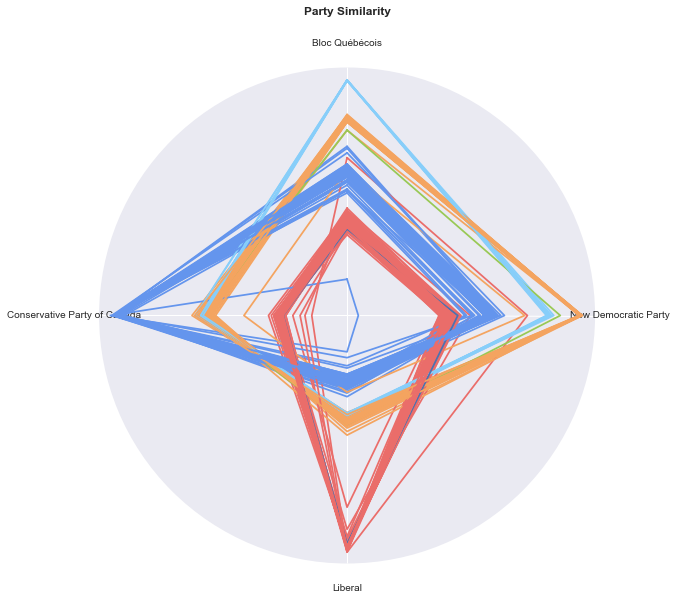

In [8]:
def get_mp_similarity(df, parliament=None):
    top5 = df.reset_index()
    if parliament:
        top5 = top5[top5["Parliament"] == parliament]
    
    per_party_per_vote = top5[top5["Party"].isin((
        "Liberal",
        "Conservative Party of Canada",
        "New Democratic Party",
        "Bloc Québécois",
    ))].groupby(
        ["Parliament", "Session", "Sitting", "Vote", "Parliamentarian: Vote", "Party"],
    )["Parliamentarian: Vote"].count().to_frame().rename(columns={"Parliamentarian: Vote": "Count"})
    per_party_per_vote = per_party_per_vote.unstack(fill_value=0)   
    per_party = top5.reset_index().groupby(
        ["Parliament", "Session", "Sitting", "Vote", "Party"],
    )["Party"].count().to_frame().rename(columns={"Party": "Total"}).unstack().fillna(100000)

    df3 = per_party_per_vote.unstack(fill_value=0).stack().reset_index()
    df1 = per_party.reset_index()
    df2 = df1
    while len(df2) < len(df3):
        df2 = df2.append(df1)
    df2 = df2.sort_values(
        ["Parliament", "Session", "Sitting", "Vote"],
    )
    df2.index = range(len(df2))

    assert len(df3) == len(df2)
    ratio = (df3["Count"] / df2["Total"]).fillna(0)
    ratio.columns = pd.MultiIndex.from_product([['Ratio'], ratio.columns])

    df3[ratio.columns] = ratio
    del df3["Count"]
    vote_ratios = df3

    import warnings
    warnings.simplefilter(action='ignore', category=UserWarning)
    warnings.simplefilter(action='ignore', category=pd.io.pytables.PerformanceWarning)

    df1 = top5.reset_index()
    dfs = []
    for row in list(df1.groupby(["Parliamentarian"]).agg({
        "Parliamentarian": "first",
    }).iterrows()):
        parliamentarian = row[0]
        dfp = df1[df1["Parliamentarian"] == parliamentarian]
        dfp = pd.merge(dfp, vote_ratios, on=["Parliament", "Session", "Sitting", "Vote", "Parliamentarian: Vote"], how='inner')
        del dfp["Parliamentarian: Vote"]
        dfg = dfp.groupby(["Parliament", "Session", "Parliamentarian", "Party"]).agg({
            ("Ratio", "Bloc Québécois"): "mean",
            ("Ratio", "Conservative Party of Canada"): "mean",
            #("Ratio", "Green Party of Canada"): "mean",
            ("Ratio", "Liberal"): "mean",
            ("Ratio", "New Democratic Party"): "mean",
        }).reset_index().set_index(["Parliament", "Session"])
        dfs.append(dfg)

    mp_party_similarity = pd.concat(dfs, ignore_index=True)
    return mp_party_similarity

mp_party_similarity = get_mp_similarity(house_vote_participants, 42)
spoke_labels = mp_party_similarity.columns.levels[1].values[0:4]
theta = radar_factory(len(spoke_labels))

fig = plt.figure(figsize=(20,20))
# adjust spacing around the subplots
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
title_list = ['Party Similarity']

rows = []
colors = []
for index, row in mp_party_similarity.iterrows():
    name, party, *values = row
    try:
        color = select_by_index(parties, {"Election": [42], "Party": party})["Color"][0]
    except:
        color = "#666666"
    colors.append(color)
    rows.append(values)

data = {'Party Similarity': rows}
radial_grid = [2., 4., 6., 8.]
for n, title in enumerate(title_list):
    ax = fig.add_subplot(2, 2, n + 1, projection='radar')
    plt.rgrids(radial_grid)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(data[title], colors):
        ax.plot(theta, d, color=color)
    ax.set_varlabels(spoke_labels)
plt.show()

# TODO: Augment to show per parliament and perhaps broken down by committee source

## MPs most like and least like other parties

In [6]:
df = mp_party_similarity.reset_index()
for source in mp_party_similarity.columns.levels[1].values[0:5]:
    if not source:
        continue
    if source == "Green Party of Canada":
        continue
    for target in mp_party_similarity.columns.levels[1].values[0:5]:
        if target:
            display(HTML("""<h3>{} MPs</h3>""".format(source)))
            display(HTML("""<h4>Most like {}</h4>""".format(target)))
            display(df[df["Party"] == source].sort_values(("Ratio", target), ascending=False).head(5))
            display(HTML("""<h4>Least like {}</h4>""".format(target)))
            display(df[df["Party"] == source].sort_values(("Ratio", target)).head(5))

index   Parliamentarian           Party          Ratio  \
                                            Bloc Québécois   
127   127    Gill, Marilène  Bloc Québécois       0.995303   
115   115     Fortin, Rhéal  Bloc Québécois       0.994130   
43     43  Boudrias, Michel  Bloc Québécois       0.993817   
246   246    Pauzé, Monique  Bloc Québécois       0.993767   
24     24   Beaulieu, Mario  Bloc Québécois       0.993659   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
127                     0.594902  0.403282             0.847793  
115                     0.600167  0.387732             0.866968  
43                      0.596812  0.394563             0.854275  
246                     0.623028  0.390402             0.838343  
24                      0.624024  0.385060             0.846614

index         Parliamentarian           Party          Ratio  \
                                                  Bloc Québécois   
313   313          Thériault, Luc  Bloc Québécois       0.991303   
201   201           Marcil, Simon  Bloc Québécois       0.991628   
304   304      Ste-Marie, Gabriel  Bloc Québécois       0.991877   
252   252        Plamondon, Louis  Bloc Québécois       0.993146   
22     22  Barsalou-Duval, Xavier  Bloc Québécois       0.993331   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
313                     0.589366  0.383196             0.847200  
201                     0.594862  0.393530             0.851836  
304                     0.599383  0.387527             0.843359  
252                     0.598055  0.382977             0.855631  
22                      0.598864  0.398796             0.834122

index         Parliamentarian           Party          Ratio  \
                                                  Bloc Québécois   
24     24         Beaulieu, Mario  Bloc Québécois       0.993659   
246   246          Pauzé, Monique  Bloc Québécois       0.993767   
115   115           Fortin, Rhéal  Bloc Québécois       0.994130   
304   304      Ste-Marie, Gabriel  Bloc Québécois       0.991877   
22     22  Barsalou-Duval, Xavier  Bloc Québécois       0.993331   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
24                      0.624024  0.385060             0.846614  
246                     0.623028  0.390402             0.838343  
115                     0.600167  0.387732             0.866968  
304                     0.599383  0.387527             0.843359  
22                      0.598864  0.398796             0.834122

index   Parliamentarian           Party          Ratio  \
                                            Bloc Québécois   
313   313    Thériault, Luc  Bloc Québécois       0.991303   
201   201     Marcil, Simon  Bloc Québécois       0.991628   
127   127    Gill, Marilène  Bloc Québécois       0.995303   
43     43  Boudrias, Michel  Bloc Québécois       0.993817   
252   252  Plamondon, Louis  Bloc Québécois       0.993146   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
313                     0.589366  0.383196             0.847200  
201                     0.594862  0.393530             0.851836  
127                     0.594902  0.403282             0.847793  
43                      0.596812  0.394563             0.854275  
252                     0.598055  0.382977             0.855631

index         Parliamentarian           Party          Ratio  \
                                                  Bloc Québécois   
127   127          Gill, Marilène  Bloc Québécois       0.995303   
22     22  Barsalou-Duval, Xavier  Bloc Québécois       0.993331   
43     43        Boudrias, Michel  Bloc Québécois       0.993817   
201   201           Marcil, Simon  Bloc Québécois       0.991628   
246   246          Pauzé, Monique  Bloc Québécois       0.993767   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
127                     0.594902  0.403282             0.847793  
22                      0.598864  0.398796             0.834122  
43                      0.596812  0.394563             0.854275  
201                     0.594862  0.393530             0.851836  
246                     0.623028  0.390402             0.838343

index     Parliamentarian           Party          Ratio  \
                                              Bloc Québécois   
252   252    Plamondon, Louis  Bloc Québécois       0.993146   
313   313      Thériault, Luc  Bloc Québécois       0.991303   
24     24     Beaulieu, Mario  Bloc Québécois       0.993659   
304   304  Ste-Marie, Gabriel  Bloc Québécois       0.991877   
115   115       Fortin, Rhéal  Bloc Québécois       0.994130   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
252                     0.598055  0.382977             0.855631  
313                     0.589366  0.383196             0.847200  
24                      0.624024  0.385060             0.846614  
304                     0.599383  0.387527             0.843359  
115                     0.600167  0.387732             0.866968

index   Parliamentarian           Party          Ratio  \
                                            Bloc Québécois   
115   115     Fortin, Rhéal  Bloc Québécois       0.994130   
252   252  Plamondon, Louis  Bloc Québécois       0.993146   
43     43  Boudrias, Michel  Bloc Québécois       0.993817   
201   201     Marcil, Simon  Bloc Québécois       0.991628   
127   127    Gill, Marilène  Bloc Québécois       0.995303   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
115                     0.600167  0.387732             0.866968  
252                     0.598055  0.382977             0.855631  
43                      0.596812  0.394563             0.854275  
201                     0.594862  0.393530             0.851836  
127                     0.594902  0.403282             0.847793

index         Parliamentarian           Party          Ratio  \
                                                  Bloc Québécois   
22     22  Barsalou-Duval, Xavier  Bloc Québécois       0.993331   
246   246          Pauzé, Monique  Bloc Québécois       0.993767   
304   304      Ste-Marie, Gabriel  Bloc Québécois       0.991877   
24     24         Beaulieu, Mario  Bloc Québécois       0.993659   
313   313          Thériault, Luc  Bloc Québécois       0.991303   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
22                      0.598864  0.398796             0.834122  
246                     0.623028  0.390402             0.838343  
304                     0.599383  0.387527             0.843359  
24                      0.624024  0.385060             0.846614  
313                     0.589366  0.383196             0.847200

index   Parliamentarian                         Party          Ratio  \
                                                          Bloc Québécois   
28     28       Benzen, Bob  Conservative Party of Canada       0.700242   
168   168  Kusie, Stephanie  Conservative Party of Canada       0.691898   
227   227        Motz, Glen  Conservative Party of Canada       0.671376   
179   179      Lebel, Denis  Conservative Party of Canada       0.621998   
232   232       Nater, John  Conservative Party of Canada       0.621190   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
28                      0.983881  0.260049             0.619108  
168                     0.984553  0.269924             0.613495  
227                     0.992935  0.268213             0.648059  
179                     0.977755  0.232666             0.606615  
232                     0.985216  0.245439             0.619428

index  Parliamentarian                         Party          Ratio  \
                                                         Bloc Québécois   
144   144     Hillyer, Jim  Conservative Party of Canada       0.111111   
141   141  Harper, Stephen  Conservative Party of Canada       0.493827   
240   240   Obhrai, Deepak  Conservative Party of Canada       0.504386   
284   284   Scheer, Andrew  Conservative Party of Canada       0.505906   
239   239    O'Toole, Erin  Conservative Party of Canada       0.506328   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
144                     1.000000  0.111111             0.000000  
141                     0.983510  0.172938             0.472443  
240                     0.938940  0.210841             0.571192  
284                     0.982083  0.257992             0.516169  
239                     0.987619  0.242821             0.480514

index    Parliamentarian                         Party          Ratio  \
                                                           Bloc Québécois   
144   144       Hillyer, Jim  Conservative Party of Canada       0.111111   
227   227         Motz, Glen  Conservative Party of Canada       0.671376   
182   182  Leitch, K. Kellie  Conservative Party of Canada       0.589601   
109   109      Finley, Diane  Conservative Party of Canada       0.566096   
145   145      Hoback, Randy  Conservative Party of Canada       0.594288   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
144                     1.000000  0.111111             0.000000  
227                     0.992935  0.268213             0.648059  
182                     0.991079  0.223718             0.589610  
109                     0.988386  0.287110             0.578697  
145                     0.987854  0.232581             0.587073

index    Parliamentarian                         Party          Ratio  \
                                                           Bloc Québécois   
240   240     Obhrai, Deepak  Conservative Party of Canada       0.504386   
65     65  Chong, Michael D.  Conservative Party of Canada       0.545603   
163   163        Kent, Peter  Conservative Party of Canada       0.611121   
42     42    Boucher, Sylvie  Conservative Party of Canada       0.612389   
303   303     Stanton, Bruce  Conservative Party of Canada       0.597134   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
240                     0.938940  0.210841             0.571192  
65                      0.948453  0.309999             0.576489  
163                     0.953199  0.255865             0.614080  
42                      0.959035  0.249876             0.607387  
303                     0.965346  0.272120             0.594439

index    Parliamentarian                         Party          Ratio  \
                                                           Bloc Québécois   
65     65  Chong, Michael D.  Conservative Party of Canada       0.545603   
30     30    Bernier, Maxime  Conservative Party of Canada       0.528101   
109   109      Finley, Diane  Conservative Party of Canada       0.566096   
198   198     Maguire, Larry  Conservative Party of Canada       0.584542   
31     31      Berthold, Luc  Conservative Party of Canada       0.584693   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
65                      0.948453  0.309999             0.576489  
30                      0.975117  0.294095             0.511536  
109                     0.988386  0.287110             0.578697  
198                     0.979114  0.278775             0.571928  
31                      0.973474  0.272579             0.589063

index  Parliamentarian                         Party          Ratio  \
                                                         Bloc Québécois   
144   144     Hillyer, Jim  Conservative Party of Canada       0.111111   
162   162    Kenney, Jason  Conservative Party of Canada       0.511111   
141   141  Harper, Stephen  Conservative Party of Canada       0.493827   
38     38   Blaney, Steven  Conservative Party of Canada       0.592397   
331   331    Watts, Dianne  Conservative Party of Canada       0.610335   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
144                     1.000000  0.111111             0.000000  
162                     0.975028  0.137055             0.504062  
141                     0.983510  0.172938             0.472443  
38                      0.973573  0.183218             0.583501  
331                     0.983217  0.210112             0.612265

index Parliamentarian                         Party          Ratio  \
                                                        Bloc Québécois   
227   227      Motz, Glen  Conservative Party of Canada       0.671376   
129   129     Godin, Joël  Conservative Party of Canada       0.618229   
232   232     Nater, John  Conservative Party of Canada       0.621190   
28     28     Benzen, Bob  Conservative Party of Canada       0.700242   
163   163     Kent, Peter  Conservative Party of Canada       0.611121   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
227                     0.992935  0.268213             0.648059  
129                     0.976672  0.237334             0.631828  
232                     0.985216  0.245439             0.619428  
28                      0.983881  0.260049             0.619108  
163                     0.953199  0.255865             0.614080

index  Parliamentarian                         Party          Ratio  \
                                                         Bloc Québécois   
144   144     Hillyer, Jim  Conservative Party of Canada       0.111111   
141   141  Harper, Stephen  Conservative Party of Canada       0.493827   
239   239    O'Toole, Erin  Conservative Party of Canada       0.506328   
162   162    Kenney, Jason  Conservative Party of Canada       0.511111   
30     30  Bernier, Maxime  Conservative Party of Canada       0.528101   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
144                     1.000000  0.111111             0.000000  
141                     0.983510  0.172938             0.472443  
239                     0.987619  0.242821             0.480514  
162                     0.975028  0.137055             0.504062  
30                      0.975117  0.294095             0.511536

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
52     52          Bélanger, Mauril  Liberal       0.650000   
277   277      Sajjan, Harjit Singh  Liberal       0.426156   
137   137           Hajdu, Patricia  Liberal       0.415947   
102   102  Erskine-Smith, Nathaniel  Liberal       0.414906   
142   142         Harvey, Thomas J.  Liberal       0.410905   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
52                      0.106471  1.000000             0.750000  
277                     0.266091  0.978805             0.442571  
137                     0.269278  0.976904             0.422462  
102                     0.230091  0.898201             0.495872  
142                     0.298526  0.966073             0.455277

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
119   119        Freeland, Chrystia  Liberal       0.308140   
234   234                  Ng, Mary  Liberal       0.319385   
171   171  Lambropoulos, Emmanuella  Liberal       0.325278   
113   113               Foote, Judy  Liberal       0.330896   
114   114             Fortier, Mona  Liberal       0.333565   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
119                     0.252980  0.930108             0.366379  
234                     0.242696  0.997529             0.380637  
171                     0.158316  0.997411             0.423054  
113                     0.190609  0.800324             0.358828  
114                     0.258473  0.997580             0.372707

index    Parliamentarian    Party          Ratio  \
                                      Bloc Québécois   
142   142  Harvey, Thomas J.  Liberal       0.410905   
63     63       Chan, Arnold  Liberal       0.399267   
270   270      Rota, Anthony  Liberal       0.371912   
213   213        McKay, John  Liberal       0.389711   
64     64        Chen, Shaun  Liberal       0.364133   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
142                     0.298526  0.966073             0.455277  
63                      0.286194  0.957838             0.436922  
270                     0.275894  0.962107             0.430911  
213                     0.275083  0.973684             0.438354  
64                      0.274603  0.978419             0.427986

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
52     52          Bélanger, Mauril  Liberal       0.650000   
316   316            Tootoo, Hunter  Liberal       0.402985   
171   171  Lambropoulos, Emmanuella  Liberal       0.325278   
113   113               Foote, Judy  Liberal       0.330896   
77     77           DeCourcey, Matt  Liberal       0.366905   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
52                      0.106471  1.000000             0.750000  
316                     0.136854  0.996621             0.400016  
171                     0.158316  0.997411             0.423054  
113                     0.190609  0.800324             0.358828  
77                      0.221796  0.978736             0.374758

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
52     52          Bélanger, Mauril  Liberal       0.650000   
114   114             Fortier, Mona  Liberal       0.333565   
234   234                  Ng, Mary  Liberal       0.319385   
171   171  Lambropoulos, Emmanuella  Liberal       0.325278   
316   316            Tootoo, Hunter  Liberal       0.402985   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
52                      0.106471  1.000000             0.750000  
114                     0.258473  0.997580             0.372707  
234                     0.242696  0.997529             0.380637  
171                     0.158316  0.997411             0.423054  
316                     0.136854  0.996621             0.400016

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
113   113               Foote, Judy  Liberal       0.330896   
102   102  Erskine-Smith, Nathaniel  Liberal       0.414906   
119   119        Freeland, Chrystia  Liberal       0.308140   
243   243  Ouellette, Robert-Falcon  Liberal       0.380117   
241   241          Oliphant, Robert  Liberal       0.354036   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
113                     0.190609  0.800324             0.358828  
102                     0.230091  0.898201             0.495872  
119                     0.252980  0.930108             0.366379  
243                     0.260354  0.939897             0.448485  
241                     0.243742  0.956269             0.418351

index           Parliamentarian    Party          Ratio  \
                                             Bloc Québécois   
52     52          Bélanger, Mauril  Liberal       0.650000   
102   102  Erskine-Smith, Nathaniel  Liberal       0.414906   
142   142         Harvey, Thomas J.  Liberal       0.410905   
296   296             Sikand, Gagan  Liberal       0.392166   
243   243  Ouellette, Robert-Falcon  Liberal       0.380117   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
52                      0.106471  1.000000             0.750000  
102                     0.230091  0.898201             0.495872  
142                     0.298526  0.966073             0.455277  
296                     0.258538  0.976651             0.451782  
243                     0.260354  0.939897             0.448485

index     Parliamentarian    Party          Ratio  \
                                       Bloc Québécois   
92     92      Duncan, Kirsty  Liberal       0.354285   
113   113         Foote, Judy  Liberal       0.330896   
247   247   Peschisolido, Joe  Liberal       0.348697   
119   119  Freeland, Chrystia  Liberal       0.308140   
155   155       Joly, Mélanie  Liberal       0.352019   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
92                      0.235567  0.978704             0.357763  
113                     0.190609  0.800324             0.358828  
247                     0.226368  0.980533             0.361524  
119                     0.252980  0.930108             0.366379  
155                     0.224959  0.980156             0.370388

index       Parliamentarian                 Party          Ratio  \
                                                      Bloc Québécois   
228   228    Mulcair, Thomas J.  New Democratic Party       0.841700   
44     44  Boulerice, Alexandre  New Democratic Party       0.839472   
85     85         Donnelly, Fin  New Democratic Party       0.836285   
274   274       Saganash, Romeo  New Democratic Party       0.836122   
138   138    Hardcastle, Cheryl  New Democratic Party       0.834909   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
228                     0.573265  0.416328             0.987914  
44                      0.604825  0.382899             0.983131  
85                      0.617598  0.409498             0.988211  
274                     0.592415  0.415691             0.987319  
138                     0.561111  0.397166             0.990005

index     Parliamentarian                 Party          Ratio  \
                                                    Bloc Québécois   
224   224    Moore, Christine  New Democratic Party       0.596574   
154   154  Jolibois, Georgina  New Democratic Party       0.772102   
199   199  Malcolmson, Sheila  New Democratic Party       0.807995   
15     15        Ashton, Niki  New Democratic Party       0.808979   
259   259      Rankin, Murray  New Democratic Party       0.809195   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
224                     0.407402  0.290188             0.737651  
154                     0.577917  0.480632             0.982112  
199                     0.578492  0.422353             0.983669  
15                      0.533219  0.464362             0.993661  
259                     0.567030  0.433492             0.984941

index       Parliamentarian                 Party          Ratio  \
                                                      Bloc Québécois   
72     72        Cullen, Nathan  New Democratic Party       0.820685   
334   334            Weir, Erin  New Democratic Party       0.814309   
85     85         Donnelly, Fin  New Democratic Party       0.836285   
27     27         Benson, Sheri  New Democratic Party       0.820668   
44     44  Boulerice, Alexandre  New Democratic Party       0.839472   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
72                      0.637840  0.380529             0.990825  
334                     0.625372  0.389292             0.978216  
85                      0.617598  0.409498             0.988211  
27                      0.609792  0.406962             0.987868  
44                      0.604825  0.382899             0.983131

index   Parliamentarian                 Party          Ratio  \
                                                  Bloc Québécois   
224   224  Moore, Christine  New Democratic Party       0.596574   
15     15      Ashton, Niki  New Democratic Party       0.808979   
204   204  Mathyssen, Irene  New Democratic Party       0.821465   
159   159     Julian, Peter  New Democratic Party       0.810097   
11     11    Angus, Charlie  New Democratic Party       0.821094   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
224                     0.407402  0.290188             0.737651  
15                      0.533219  0.464362             0.993661  
204                     0.540784  0.433538             0.991321  
159                     0.544003  0.449215             0.989812  
11                      0.551730  0.422999             0.984549

index        Parliamentarian                 Party          Ratio  \
                                                       Bloc Québécois   
154   154     Jolibois, Georgina  New Democratic Party       0.772102   
15     15           Ashton, Niki  New Democratic Party       0.808979   
159   159          Julian, Peter  New Democratic Party       0.810097   
319   319         Trudel, Karine  New Democratic Party       0.815946   
93     93  Duncan, Linda Francis  New Democratic Party       0.822461   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
154                     0.577917  0.480632             0.982112  
15                      0.533219  0.464362             0.993661  
159                     0.544003  0.449215             0.989812  
319                     0.559866  0.442257             0.985305  
93                      0.589468  0.436305             0.983280

index       Parliamentarian                 Party          Ratio  \
                                                      Bloc Québécois   
224   224      Moore, Christine  New Democratic Party       0.596574   
72     72        Cullen, Nathan  New Democratic Party       0.820685   
44     44  Boulerice, Alexandre  New Democratic Party       0.839472   
334   334            Weir, Erin  New Democratic Party       0.814309   
195   195   MacGregor, Alistair  New Democratic Party       0.817638   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
224                     0.407402  0.290188             0.737651  
72                      0.637840  0.380529             0.990825  
44                      0.604825  0.382899             0.983131  
334                     0.625372  0.389292             0.978216  
195                     0.604644  0.396788             0.982683

index     Parliamentarian                 Party          Ratio  \
                                                    Bloc Québécois   
15     15        Ashton, Niki  New Democratic Party       0.808979   
56     56          Caron, Guy  New Democratic Party       0.826356   
204   204    Mathyssen, Irene  New Democratic Party       0.821465   
72     72      Cullen, Nathan  New Democratic Party       0.820685   
138   138  Hardcastle, Cheryl  New Democratic Party       0.834909   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
15                      0.533219  0.464362             0.993661  
56                      0.552667  0.433605             0.993299  
204                     0.540784  0.433538             0.991321  
72                      0.637840  0.380529             0.990825  
138                     0.561111  0.397166             0.990005

index     Parliamentarian                 Party          Ratio  \
                                                    Bloc Québécois   
224   224    Moore, Christine  New Democratic Party       0.596574   
334   334          Weir, Erin  New Democratic Party       0.814309   
35     35     Blaikie, Daniel  New Democratic Party       0.813375   
76     76         Davies, Don  New Democratic Party       0.816633   
154   154  Jolibois, Georgina  New Democratic Party       0.772102   

                                                                 
    Conservative Party of Canada   Liberal New Democratic Party  
224                     0.407402  0.290188             0.737651  
334                     0.625372  0.389292             0.978216  
35                      0.601563  0.413172             0.979177  
76                      0.599619  0.425508             0.980779  
154                     0.577917  0.480632             0.982112